14.02.2025

In [1]:
# from ...DementiaMRI.Architectures.VAE import VAE
from Data.load import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from Metrics.metrics import NMSE, SSIM, NRMSE
import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K

from skimage.metrics import structural_similarity as ssim

import time
import math
import nibabel as nib

Adjustable Autoencoder (AE) model will be moved to architectures once finished.

In [2]:
train, test = load(take=30, train_test_split=0.8) # spatially normalized brains were put in this path "\Data\Pre-processed"
print(train.shape, test.shape)

Loading images: 100%|██████████| 30/30 [00:08<00:00,  3.72it/s]

(24, 80, 96, 80) (6, 80, 96, 80)


In [16]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss="mse", #of any other funciton
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss = loss
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        shape_changed = False
        if self.input_shape[-1] > 3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed = True
        if len(self.input_shape) > 4:
            self.input_shape = self.input_shape[-4:]
            shape_changed = True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            # Sampling layer
            def sampling(args):
                mean, log_var = args
                epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
                return mean + K.exp(0.5 * log_var) * epsilon
            
            z = layers.Lambda(sampling, name="z")([self.mean, self.log_var])
            self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")

        else:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model

        # maybe we can remove this, as the self.latent_dim is the same as x.shape[1:] ? test this once it works.
        #if self.VAE_model:
        #    print("abc:",(self.latent_dim,))
        latent_input = x = layers.Input(shape=(self.latent_dim,))  # Latent input
        #else:
        #    print("abc:", x.shape[1:])
        #    latent_input = x = layers.Input(shape=x.shape[1:])  # Latent input
        
        # Calculate the expected target shape after decoder layers

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(pre_flatten_shape[1:]), activation="leaky_relu")(latent_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)

        # - Add decoder layers
        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full VAE
        if self.VAE_model:
            mean, log_var, z = self.encoder(input_layer)
            autoencoder_output = self.decoder(z)
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        else:
            autoencoder_output = self.decoder(self.encoder(input_layer))
            self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        
        # 4. GPU or CPU assignment (based on self.GPU)
        #self.autoencoder.compile(optimizer='adam', loss='mse')
        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            # Set device to GPU if available
            with tf.device('/GPU:0'):
                if self.VAE_model:
                    self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)
                else:
                    self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)

        else:
            # Default to CPU
            if self.VAE_model:
                self.autoencoder.compile(optimizer='adam', loss=self.vae_loss)
            else:
                self.autoencoder.compile(optimizer='adam', loss=self.loss)

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0:
                        self.save(save_path, name=f"{self.name}_epoch{epoch}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0:
                    self.save(save_path, name=f"{self.name}_epoch{epoch}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def vae_loss_old(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
        reconstruction_loss = self.loss(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    
    def vae_loss(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""

        # Reconstruction loss (SSIM loss)
        reconstruction_loss = self.loss(y_true, y_pred)

        # Extract mean and log variance from the encoder's output
        mean, log_var, _ = self.encoder(y_true)  # Use actual values, not placeholders

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    #def sample2(mu, logvar):
    #    batch = tf.shape(mu)[0]
    #    dim = tf.shape(mu)[1]
    #    epsilon = tf.random.normal(shape=(batch, dim))
    #    return mu + tf.exp(0.5 * logvar) * epsilon

    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")

        autoencoder = tf.keras.models.load_model(autoencoder_path)
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(ae.vae_loss, optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae

In [30]:
# USEFULL FUNCTIONS
def plot_middle_slices_in_range(folder_path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed", n1=0, n2=9, axis=1):
    "Function to plot the middle slices of images between n1 and n2 in a single figure"
    # Get a sorted list of all files in the directory excluding mask files
    all_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.nii.gz') and not f.endswith('_mask.nii.gz')]
    )
    
    # Filter files between n1 and n2
    selected_files = all_files[n1:n2]
    num_images = len(selected_files)
    
    # Determine grid size for the plot
    cols = math.ceil(math.sqrt(num_images))  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Number of rows in the grid
    
    # Create a figure for plotting
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten to easily iterate over axes
    
    for i, file in enumerate(selected_files):
        file_path = os.path.join(folder_path, file)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Calculate the middle index along axis 0
        middle_index = img_data.shape[axis] // 2
        
        # Plot the middle slice on the current axis
        axes[i].imshow(img_data[middle_index, :, :].T, cmap='gray', origin="lower")
        axes[i].set_title(file_path.split("\\")[-1].split("_")[0], fontsize=8)
        axes[i].axis('off')
    
    # Hide unused axes if the grid is larger than the number of images
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_models_training_time(models_list, fig_size=""):
    training_times = []
    names = []
    for m in models_list:
        if hasattr(m, 'training_time') and m.training_time is not None:
            training_times.append(m.training_time)
            names.append(m.name)

    if training_times:
        if fig_size: 
            plt.figure(figsize=fig_size)
        plt.bar(names, training_times)
        plt.xlabel('Model index')
        plt.ylabel('Training time (seconds)')
        plt.title('Training time of models')
        plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
        plt.show()

def compare_models_loss_history(models, log10=True, fig_size="", title="Model's val_loss history"):
    """
    Compares the loss histories of multiple models by plotting their log-transformed losses.

    Parameters:
    - models: list of model objects, each containing a 'log.history["loss"]' attribute and a 'name'.

    Returns:
    - None: Displays a plot of the loss histories.
    """
    if fig_size: 
        plt.figure(figsize=fig_size)
    for i, model in enumerate(models):
        #color = decimal_to_rgb(i, len(models))
        #color = "#{:02x}{:02x}{:02x}".format(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        #y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
        
        # Sorry for the mess, but I wanted this to work for two different classes
        if isinstance(model.history, tf.keras.callbacks.History):
            y = [model.history.history["val_loss"], np.log10(model.history.history["val_loss"])][log10]
        else:
            y = [model.history["val_loss"], np.log10(model.history["val_loss"])][log10]
        plt.plot(y, label=model.name) #, color=color
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss Log10") if log10 else plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_images(images, dimensions, fig_size=(10,8), titles=[], top_title="Image Gallery", cmap="viridis"):
    """
    Plots a grid of images with corresponding titles.

    Parameters:
    - images: list of numpy arrays, the images to be displayed.
    - dimensions: tuple of int (rows, cols), grid layout for images.
    - fig_size: tuple for the figure size, eg (10,8)
    - titles: list of str, the titles for each image.
    - top_title: str, optional, the title of the overall figure.

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=fig_size)
    plt.suptitle(top_title, fontsize=12, fontweight="bold", y=0.99)
    for i, img in enumerate(images):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        plt.imshow(img, cmap=cmap)
        if len(titles) == len(images):
            plt.title(titles[i], fontsize=10)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

def compare_models_reconstruction(brain_scan_id, models_list):
    images = []
    for m in models_list:
        if m.VAE_model:
            latent = m.encode(test)[2]
        else:            
            latent = m.encode(test)
        recon = m.decode(latent)
        input_image = np.rot90(test[brain_scan_id][40].reshape((96, 80)))
        recon_image = np.rot90(recon[brain_scan_id][40])[:,:,0] # recon shape is 3dim we need -> 2d
        images.append(input_image)
        images.append(recon_image)
        images.append(input_image - recon_image)
    return images, latent


# METRICS
def MSE_loss(y_true, y_pred):
    """Mean Squared Error (MSE) loss"""
    return tf.reduce_mean(tf.square(y_true - y_pred))

def NMSE_loss(y_true, y_pred):
    """Normalized Mean Squared Error (NMSE) loss"""
    return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true))

def NRMSE_loss(y_true, y_pred):
    """Normalized Root Mean Squared Error (NRMSE) loss"""
    range_val = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) / (range_val + 1e-8)  # Avoid division by zero

def SSIM_loss(y_true, y_pred):
    """SSIM loss (1 - SSIM for minimization)"""
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))



In [81]:
models_list4 = [
    AE(name="AE (3h, 16-64f, 128L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=False, loss=SSIM_loss),
]

for m in models_list4:
    m.train(train, epochs=30, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 0.6739 - val_loss: 0.7966
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.7621 - val_loss: 0.8034
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.7808 - val_loss: 0.6956
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.7536 - val_loss: 0.8173
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 0.8183 - val_loss: 0.8251
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.8072 - val_loss: 0.6929
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.6784 - val_loss: 0.5755
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.6804 - val_loss: 0.5751
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 0.5806 - val_loss: 0.6024
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.6034 - val_loss: 0.5820
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.5795 - val_loss: 0.5685
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.5678 - val_loss: 0.5659
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.5650 - val_loss: 0.56

In [82]:
models_list4.append(
    AE(name="AE (3h, 16-64f, 128L, SSIM_loss)", input_shape=train.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    ], VAE_model=False, loss=SSIM_loss)
)

for m in [models_list4[-1]]:
    m.train(train, epochs=30, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.6786 - val_loss: 0.7151
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.6930 - val_loss: 0.8025
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.7470 - val_loss: 0.5894
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.6091 - val_loss: 0.5796
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.5832 - val_loss: 0.5764
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.5760 - val_loss: 0.6127
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.6042 - val_loss: 0.5787
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.5885 - val_loss: 0.5790
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.5845 - val_loss: 0.5631
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.5664 - val_loss: 0.5615
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.5625 - val_loss: 0.5649
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.5635 - val_loss: 0.5573
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.5565 - val_loss: 0.550

In [97]:
for m in models_list4:
    m.train(train, epochs=20, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.3116 - val_loss: 0.3362
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3156 - val_loss: 0.3491
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3183 - val_loss: 0.3364
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3223 - val_loss: 0.3287
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3132 - val_loss: 0.3263
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3124 - val_loss: 0.3241
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3074 - val_loss: 0.3206
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3058 - val_loss: 0.3264
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3023 - val_loss: 0.3181
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2955 - val_loss: 0.3165
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2962 - val_loss: 0.3149
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2914 - val_loss: 0.3149
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2863 - val_loss: 0.3120
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2868 - val_loss: 0.3113
2/2 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
0.5711922331573415
[[-0.01300001 -0.00932547 -0.01273831 -0.01163019 -0.01000435 -0.02105962
  -0.01845819 -0.03614436 -0.0141449  -0.01924463 -0.00935986 -0.0120004
  -0.01405315 -0.00757183 -0.00602359 -0.00998564 -0.00991304 -0.01286916
  -0.01669142 -0.00742212 -0.0108065  -0.01198064 -0.01326584 -0.00288085
  -0.02056646 -0.01407188 -0.00768099 -0.01444755 -0.02273934 -0.00850491
  -0.01686377 -0.01467892 -0.01094353 -0.01520379 -0.01321979 -0.01399889
  -0.01668417 -0.00740796 -0.00918171 -0.01355755 -0.01239086 -0.00734379
  -0.01345261 -0.01385604 -0.01076005 -0.01276118 -0.01044806 -0.00178814
  -0.0088706  -0.01536846 -0.00887045 -0.01127342 -0.01483991 -0.00877707
  -0.01014158 -0.00876473 -0.00342561 -0.0096137  -0.02105651 -0.01390427
  -0.0137046  -0.00905123 -0.01849407 -0.00963158 -0.02185055 -0.00846667
  -0.01180932 

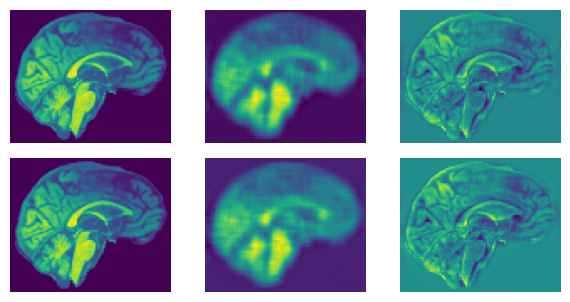

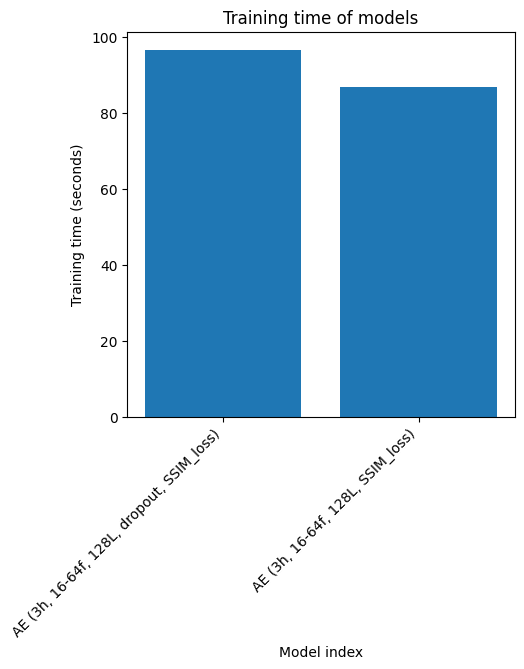

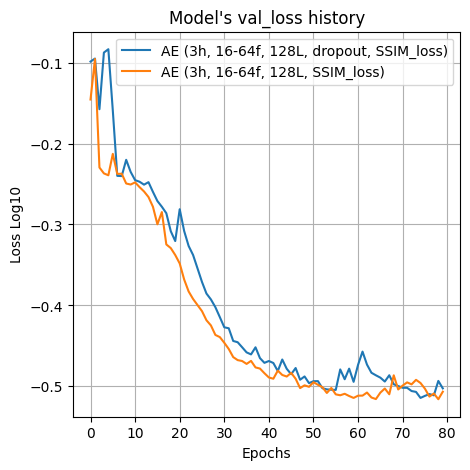

In [98]:
if 'models_list4' in locals(): # if the variable exists
    images, latent = compare_models_reconstruction(brain_scan_id=0, models_list=models_list4)
    print(SSIM(images[0], images[1]))
    print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list4, fig_size=(5,5))
    compare_models_loss_history(models_list4, log10=True, fig_size=(5,5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


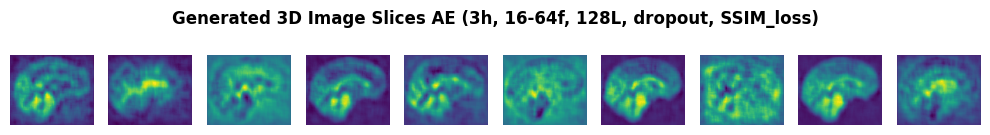

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


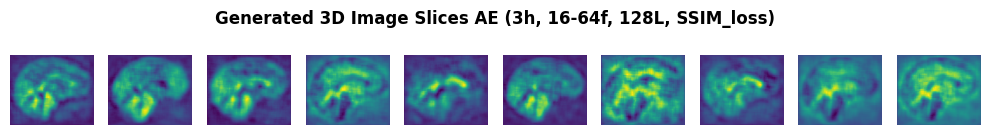

In [99]:
for m in models_list4:
    m.latent_dim = 128 # yes you have to add this (could be saved and loaded/opened/inited by save name)
    num_samples = 10
    slice_index = 40

    # Plot generated 3d image slices
    generated_volumes = m.decoder.predict(np.random.normal(size=(num_samples, m.latent_dim)))
    images = [np.rot90(vol[slice_index]) for vol in generated_volumes]  # Extract a slice from each 3D volume
    plot_images(images, dimensions=(5, num_samples), fig_size=(10,5), top_title="Generated 3D Image Slices "+m.name)

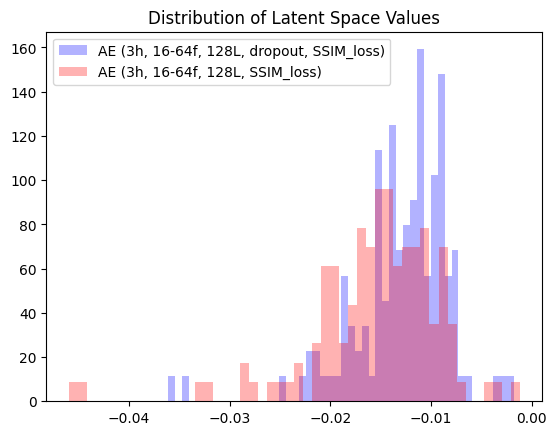

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=models_list4[0].name, color="blue", alpha=0.3, density=True, bins=50) # Fill
plt.hist(latent[1].flatten(), label=models_list4[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()

LETSF CUKING GOOOO

In [ ]:
models_list4 = [
    AE(name="AE (3h, 16-64f, 128L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=False, loss=SSIM_loss),
    AE(name="VAE (3h, 16-64f, 128L, dropout, SSIM_loss)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, loss=SSIM_loss),
]

for m in models_list4:
    m.train(train, epochs=30, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6555WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x00000176B82B0360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.6814

In [35]:
for m in models_list4:
    m.train(train, epochs=30, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3716 - val_loss: 0.3736
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3767 - val_loss: 0.3807
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.3808 - val_loss: 0.3561
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3521 - val_loss: 0.3731
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3688 - val_loss: 0.3543
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3523 - val_loss: 0.3556
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3491 - val_loss: 0.3584
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3535 - val_loss: 0.3454
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3397 - val_loss: 0.3417
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3396 - val_loss: 0.3420
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3349 - val_loss: 0.3417
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3345 - val_loss: 0.3344
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3288 - val_loss: 0.3267
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.3195 - val_loss: 0.3263
2/2 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
0.5639101240467191
[[-0.04169311 -0.69993275  1.0454351   1.5029281  -0.83679855  0.33223766
  -0.84493124 -0.495338    0.11845247  0.42077878 -0.32697186  0.7055439
  -0.12402807 -0.34845537  1.2027617  -1.0328095  -0.7153884  -1.883959
  -2.0089648   0.3301557   0.7794131  -0.20856258  1.005363   -0.34912473
  -0.16614711  1.28044     0.57000804 -0.31939068 -1.482673    0.5364121
  -0.20037678  1.6133485  -0.32351622  1.1953201  -1.188653    0.12185014
  -0.45889333  1.428901    2.153101    1.5223966  -0.0058509   0.7449467
  -0.07788538  0.8588096   1.4899912  -0.5003837   0.12689492  0.00584902
   1.5617617  -1.3692278   0.0371358   0.9378739   2.1967847   1.6243355
   1.1674081   0.2923329   1.71761    -0.45886445 -2.04484     0.5748304
  -0.8524806   0.73187095 -0.15050851  0.6044419  -1.6888561  -0.10721244
   0.14935906 -1.231

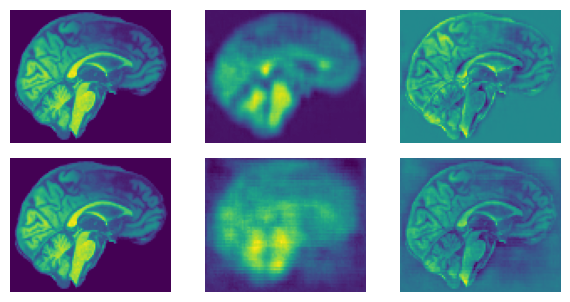

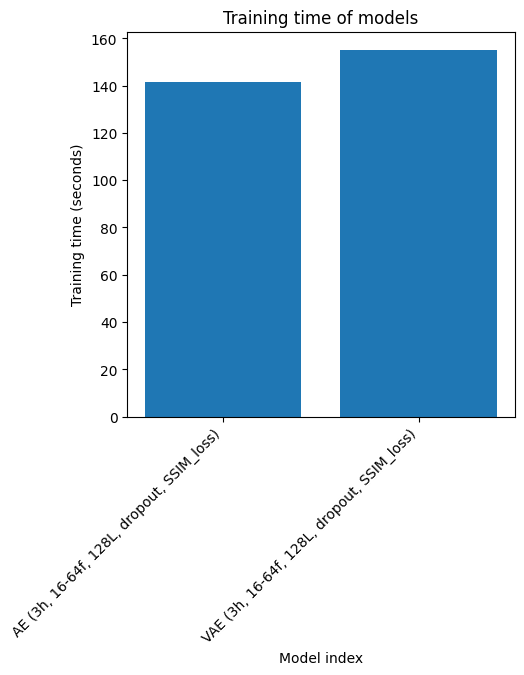

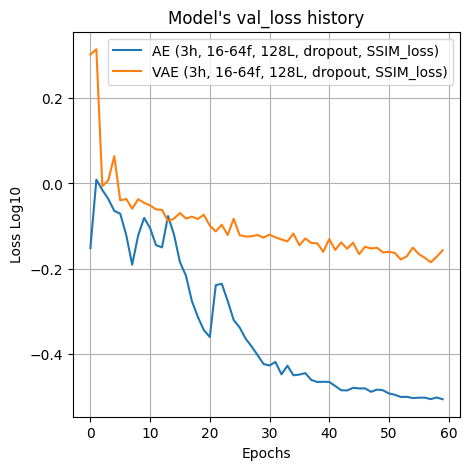

In [40]:
if 'models_list4' in locals(): # if the variable exists
    images, latent = compare_models_reconstruction(brain_scan_id=0, models_list=models_list4)
    print(SSIM(images[0], images[1]))
    print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list4, fig_size=(5,5))
    compare_models_loss_history(models_list4, log10=True, fig_size=(5,5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


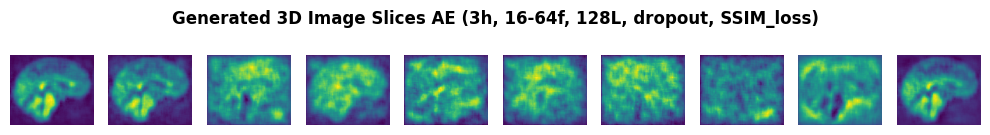

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


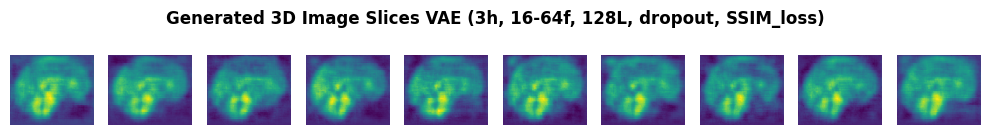

In [41]:
for m in models_list4:
    m.latent_dim = 128 # yes you have to add this (could be saved and loaded/opened/inited by save name)
    num_samples = 10
    slice_index = 40

    # Plot generated 3d image slices
    generated_volumes = m.decoder.predict(np.random.normal(size=(num_samples, m.latent_dim)))
    images = [np.rot90(vol[slice_index]) for vol in generated_volumes]  # Extract a slice from each 3D volume
    plot_images(images, dimensions=(5, num_samples), fig_size=(10,5), top_title="Generated 3D Image Slices "+m.name)

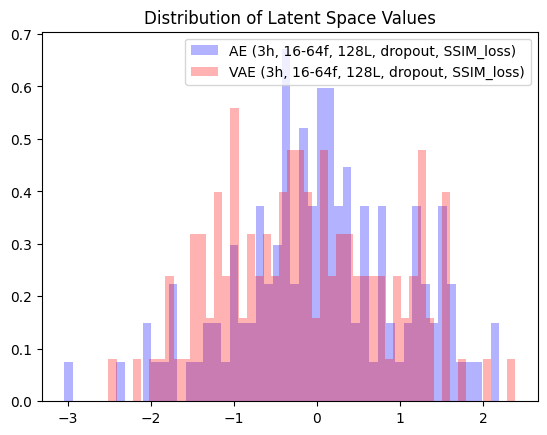

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=models_list4[0].name, color="blue", alpha=0.3, density=True, bins=50) # Fill
plt.hist(latent[1].flatten(), label=models_list4[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()

##### Success!

Priority queue:
1. Figure out how to plot up the latent space into a 2d plot for better spatial representation of healthy and sick brains.
2. Scrape off public github autoencoder repositories for inspiration/copying of AE architecture.
3. Compare models on reconstruction, but primarily on latent space plots.
4. See if you can improve the best models.